In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.collections import LineCollection

# Constants
g = 9.81
l1, l2 = 1.0, 1.0
m1, m2 = 1.0, 1.0

# Time settings
dt = 1/60
T = 20
time = np.arange(0, T, dt)

# Initial conditions
theta1 = np.zeros(len(time))
theta2 = np.zeros(len(time))
omega1 = np.zeros(len(time))
omega2 = np.zeros(len(time))

theta1[0] = np.pi / 2
theta2[0] = np.pi

# Derivative function for ODE
def derivatives(t1, t2, o1, o2):
    delta_theta = t1 - t2
    
    a1 = (-g*(2*m1+m2)*np.sin(t1) - m2*g*np.sin(t1-2*t2) - 2*np.sin(t1-t2)*m2*(o2**2*l2 + o1**2*l1*np.cos(delta_theta)))/(l1*(2*m1+m2-m2*np.cos(2*delta_theta)))
    a2 = (2*np.sin(delta_theta)*(o1**2*l1*(m1+m2) + g*(m1+m2)*np.cos(t1) + o2**2*l2*m2*np.cos(delta_theta)))/(l2*(2*m1+m2-m2*np.cos(2*delta_theta)))
    
    return o1, o2, a1, a2

# 4th-order Runge-Kutta method
for i in range(1, len(time)):
    k1_t1, k1_t2, k1_o1, k1_o2 = derivatives(theta1[i-1], theta2[i-1], omega1[i-1], omega2[i-1])
    k2_t1, k2_t2, k2_o1, k2_o2 = derivatives(theta1[i-1]+0.5*dt*k1_t1, theta2[i-1]+0.5*dt*k1_t2, omega1[i-1]+0.5*dt*k1_o1, omega2[i-1]+0.5*dt*k1_o2)
    k3_t1, k3_t2, k3_o1, k3_o2 = derivatives(theta1[i-1]+0.5*dt*k2_t1, theta2[i-1]+0.5*dt*k2_t2, omega1[i-1]+0.5*dt*k2_o1, omega2[i-1]+0.5*dt*k2_o2)
    k4_t1, k4_t2, k4_o1, k4_o2 = derivatives(theta1[i-1]+dt*k3_t1, theta2[i-1]+dt*k3_t2, omega1[i-1]+dt*k3_o1, omega2[i-1]+dt*k3_o2)
    
    omega1[i] = omega1[i-1] + (1/6)*(k1_o1 + 2*k2_o1 + 2*k3_o1 + k4_o1)*dt
    omega2[i] = omega2[i-1] + (1/6)*(k1_o2 + 2*k2_o2 + 2*k3_o2 + k4_o2)*dt
    theta1[i] = theta1[i-1] + (1/6)*(k1_t1 + 2*k2_t1 + 2*k3_t1 + k4_t1)*dt
    theta2[i] = theta2[i-1] + (1/6)*(k1_t2 + 2*k2_t2 + 2*k3_t2 + k4_t2)*dt



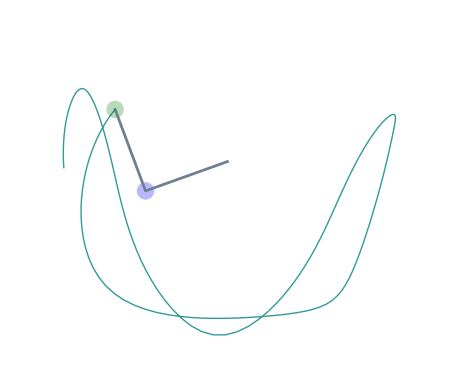

In [55]:
# For path tracing of the second bob
path_x = []
path_y = []
max_path_length = 200  # number of segments to show, adjust as needed

fig, ax = plt.subplots()
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 1.75)
ax.set_aspect('equal', 'box')
ax.axis('off')

line, = ax.plot([], [], color='slategrey', lw=2)
bob1 = plt.Circle((l1*np.sin(theta1[0]), -l1*np.cos(theta1[0])), 0.1, fc='b', alpha=0.1)
bob2 = plt.Circle((l1*np.sin(theta1[0]) + l2*np.sin(theta2[0]), -l1*np.cos(theta1[0]) - l2*np.cos(theta2[0])), 0.1, fc='g', alpha=0.1)

# Adding the path of bob2 as a LineCollection
c = 'magenta'
c = 'teal'
lc = LineCollection([], colors=c, linewidth=1, alpha=0.8)
lc.set_array(np.linspace(0, 1, max_path_length))
ax.add_collection(lc)

def init():
    line.set_data([], [])
    ax.add_patch(bob1)
    ax.add_patch(bob2)
    return line, bob1, bob2, lc

def animate(i):
    x = [0, l1*np.sin(theta1[i]), l1*np.sin(theta1[i]) + l2*np.sin(theta2[i])]
    y = [0, -l1*np.cos(theta1[i]), -l1*np.cos(theta1[i]) - l2*np.cos(theta2[i])]
    
    path_x.append(x[2])
    path_y.append(y[2])
    
    if len(path_x) > max_path_length:
        path_x.pop(0)
        path_y.pop(0)

    segments = [list(zip(path_x, path_y))]
    lc.set_segments(segments)

    # Update alpha values to create fading effect
    # lc.set_array(np.linspace(0, 1, len(path_x)))

    line.set_data(x, y)
    bob1.center = (x[1], y[1])
    bob2.center = (x[2], y[2])
    return line, bob1, bob2, lc

anim = animation.FuncAnimation(fig, animate, frames=len(time), init_func=init, blit=True, interval=dt*1000)
# anim.save('double-pendulum-with-path.mov')

# Save the animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=60, metadata=dict(artist='Me'), bitrate=1800)
anim.save(f'double-pendulum-with-path-{c}.mp4', writer=writer, dpi=300)  # Change dpi to set the resolution